In [11]:
#@title <font color='Blue'>**Import**</font>
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from IPython.display import clear_output 
import calendar
from datetime import datetime, timedelta
import math

In [3]:
#@title <font color='Blue'>**Method**</font>
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K) + (r + 0.5 *sig**2) * T )/(sig * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def bsput(S, K, T, r, sig):
    d1 = (np.log(S / K) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [4]:
#@title <font color='Blue'>**Setting**</font>
# ======== 1 ======== #
r = 0.00 # 0.0으로 두면 계산이 편해짐 -> 이자율만 이야기함.
sig = 0.2  # 주식의 변동성 - 20%가 가장 흔히 쓰는 주식의 변동성
T = 30/365 # 1년 중 30일

M = 1000 # 시뮬레이션 수 ( 100개의 시나리오를 테스트하겠다. )
N = 30 # 나눔수

dt = T/N # T를 N개로 나눠서 보겠다.
rdt = r * dt
sigsdt = sig * np.sqrt(dt)

S0 = 100
K = 100

# ======== 2 ======== #
np.random.seed(100) # 랜덤 변수 고정
S = np.empty([M,N+1]) # 100 * 31 배열
rv = np.random.normal(r*dt, sigsdt, [M,N])

# ======== 3 ======== #
for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1 + rv[i,j])

In [5]:
#@title <font color='Blue'>**Model**</font>
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
my_input = my_input + [premium]


hedge_cost = tf.keras.layers.Input(shape=(1,), name="hedge_cost")
my_input = my_input + [hedge_cost]

price = tf.keras.layers.Input(shape=(1,), name="price")
my_input = my_input + [price]

for j in range(N):

  d1 = (np.log(S[i,j]/K) + (r + 0.5 *sig**2) * (T-j*dt))/(sig * np.sqrt(T-j*dt)) # Black Scholes의 Call Option 공식
  delta = norm.cdf(d1) # Black Scholes의 Call option delta

  alpha = tf.keras.layers.Dense(32, activation='tanh')(price)
  alpha = tf.keras.layers.BatchNormalization()(alpha)

  alpha = tf.keras.layers.Dense(32, activation='relu')(price)
  alpha = tf.keras.layers.BatchNormalization()(alpha)

  alpha = tf.keras.layers.Dense(32, activation='tanh')(price)
  alpha = tf.keras.layers.BatchNormalization()(alpha)

  alpha = tf.keras.layers.Dense(1)(alpha)
  delta += alpha

  new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j))
  my_input = my_input + [new_price]

  price_inc = tf.keras.layers.Subtract(name="price_inc"+str(j))([price,new_price])
  cost = tf.keras.layers.Multiply(name="multiply"+str(j))([delta, price_inc])
  hedge_cost = tf.keras.layers.Add(name="cost_"+str(j))([hedge_cost, cost])
  price = new_price

payoff = tf.keras.layers.Lambda(lambda x : 0.5*(tf.abs(x-K) + x - K))(price)
cum_cost = tf.keras.layers.Add(name='final')([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name='final_')([cum_cost, premium])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

In [6]:
#@title <font color='Blue'>**Set Parameter**</font>

p = bscall(S0,K,T,r,sig) * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [p]+[c]+[SS]
y = bscall(S0,K,T,r,sig) * np.zeros([M,1])

In [7]:
#@title <font color='Blue'>**Fit Model**</font>
model.compile(loss='mse', optimizer='adam')
hist = model.fit(x,y, epochs=100)

Epoch 1/100
32/32 [==============================] - 12s 25ms/step - loss: 3.8447
Epoch 2/100
32/32 [==============================] - 1s 25ms/step - loss: 1.6747
Epoch 3/100
32/32 [==============================] - 1s 24ms/step - loss: 0.9495
Epoch 4/100
32/32 [==============================] - 1s 24ms/step - loss: 0.8025
Epoch 5/100
32/32 [==============================] - 1s 25ms/step - loss: 0.6992
Epoch 6/100
32/32 [==============================] - 1s 26ms/step - loss: 0.7122
Epoch 7/100
32/32 [==============================] - 1s 26ms/step - loss: 0.6627
Epoch 8/100
32/32 [==============================] - 1s 26ms/step - loss: 0.6784
Epoch 9/100
32/32 [==============================] - 1s 26ms/step - loss: 0.6406
Epoch 10/100
32/32 [==============================] - 1s 26ms/step - loss: 0.6481
Epoch 11/100
32/32 [==============================] - 1s 24ms/step - loss: 0.6756
Epoch 12/100
32/32 [==============================] - 1s 26ms/step - loss: 0.6571
Epoch 13/100
32/32 [====

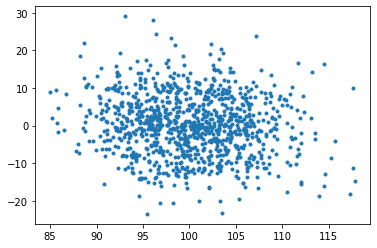

In [8]:
#@title <font color='Blue'>**Result1**</font>
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()

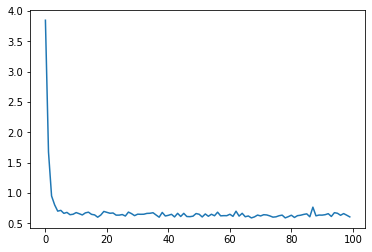

In [9]:
#@title <font color='Blue'>**Result2**</font>
plt.plot(hist.history['loss'])
plt.show()

# REAL DATA

In [12]:
#@title <font color='Blue'>**Import**</font>
!pip install yfinance
!pip install pandas_datareader
import yfinance as yf
from pandas_datareader import data as pdr
import pandas as pd
yf.pdr_override() 

clear_output()

In [13]:
#@title <font color='Blue'>**Setting**</font>
# ======== 1 ======== #
T = 30/365 # 1년 중 30일
r = 0.00 # 0.0으로 두면 계산이 편해짐 -> 이자율만 이야기함.
sig = 0.2  # 주식의 변동성 - 20%가 가장 흔히 쓰는 주식의 변동성
N = 30

# ======== 데이터 전처리 ======== #
STOCK_CODE = "^KS11"
start_date = "2016-01-01"
end_date = "2022-10-01"
testRatio = 0.3

STOCK_DATA = pdr.get_data_yahoo(STOCK_CODE, start=start_date, end=end_date)["Close"]
stockArray = STOCK_DATA.to_numpy()
M = math.floor(len(stockArray)/(N+1))
S = stockArray[:M*(N+1)].reshape(M,N+1)
K = 2000

_M = math.floor(M * testRatio) # divide criterion
S_train = S[:-_M] # Train Data
S_test = S[-_M:] # Test Data

# ======== Train Data Set ======== #
M = len(S_train)
p = []
for index in range(M):
  # if(index != M-1):
  #   sig = abs(S_train[index+1][0] - S_train[index][0]) / S_train[index][0] * 100
  premium = bscall(S_train[index][0],K,T,r,sig)
  p.append([premium])

p = p * np.ones([M,1])
c = np.zeros([M,1])
SS = [S_train[:,i].reshape(M,1) for i in range(N+1)]

x_train = [p]+[c]+[SS]
y_train = np.zeros([M,1])

[*********************100%***********************]  1 of 1 completed


In [14]:
#@title <font color='Blue'>**Fit Model**</font>
model.compile(loss='mse', optimizer='adam')
hist = model.fit(x_train, y_train, epochs=1000)
# clear_output()
print("모델 학습 완료")

Epoch 1/1000
2/2 [==============================] - 20s 53ms/step - loss: 1705.1307
Epoch 2/1000
2/2 [==============================] - 0s 50ms/step - loss: 1604.3185
Epoch 3/1000
2/2 [==============================] - 0s 48ms/step - loss: 1511.5638
Epoch 4/1000
2/2 [==============================] - 0s 55ms/step - loss: 1417.9629
Epoch 5/1000
2/2 [==============================] - 0s 73ms/step - loss: 1344.0740
Epoch 6/1000
2/2 [==============================] - 0s 44ms/step - loss: 1274.7222
Epoch 7/1000
2/2 [==============================] - 0s 44ms/step - loss: 1216.2758
Epoch 8/1000
2/2 [==============================] - 0s 46ms/step - loss: 1160.9144
Epoch 9/1000
2/2 [==============================] - 0s 41ms/step - loss: 1111.2227
Epoch 10/1000
2/2 [==============================] - 0s 29ms/step - loss: 1067.0466
Epoch 11/1000
2/2 [==============================] - 0s 32ms/step - loss: 1031.5857
Epoch 12/1000
2/2 [==============================] - 0s 30ms/step - loss: 995.6137
E

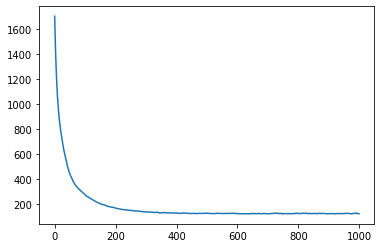

In [15]:
#@title <font color='Blue'>**Result1**</font>
plt.plot(hist.history['loss'])
plt.show()

15


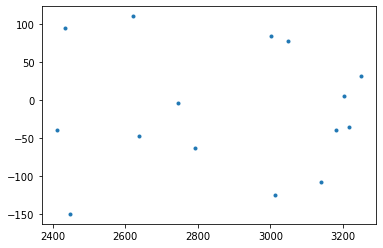

In [16]:
# ======== Test Data Set ======== #
M = len(S_test)
print(len(S_test))
p = []
for index in range(M):
  premium = bscall(S_test[index][0],K,T,r,sig)
  p.append([premium])

p = p * np.ones([M,1])
c = np.zeros([M,1])
SS = [S_test[:,i].reshape(M,1) for i in range(N+1)]

x_test = [p]+[c]+[SS]
y_test = np.zeros([M,1])


#@title <font color='Blue'>**Result2**</font>
plt.plot(S_test[:, -1], model.predict(x_test), marker = ".", linestyle='none')
plt.show()